# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [3]:
data = pd.read_csv('./raw_data/retail_train.csv')
item_features = pd.read_csv('./raw_data/product.csv')
user_features = pd.read_csv('./raw_data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [4]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [5]:
recommender = MainRecommender(data_train_lvl_1)

In [6]:
recommender.get_als_recommendations(2375, N=5)

[899624, 1106523, 1044078, 871756, 844179]

In [7]:
recommender.get_own_recommendations(2375, N=5)

[948640, 918046, 847962, 907099, 873980]

In [8]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 1044078, 1042907, 1069181, 15778319]

In [9]:
recommender.get_similar_users_recommendation(2375, N=5)

[1012801, 10457044, 896757, 1101502, 974265]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

In [10]:
def popular_recommendation(data, n=5):
    """Топ-n популярных товаров"""
    
    popular = data.groupby('item_id')['sales_value'].sum().reset_index()
    popular.sort_values('sales_value', ascending=False, inplace=True)
    
    recs = popular.head(n).item_id
    
    return recs.tolist()

In [11]:
popular_recs = popular_recommendation(data_train_lvl_1, n=50)

In [12]:
#drop those users who are absent in train dataset
data_val_lvl_1 = data_val_lvl_1[data_val_lvl_1['user_id'].isin(data_train_lvl_1['user_id'])]

In [13]:
data_train_lvl_1 = data_train_lvl_1[data_train_lvl_1['user_id'].isin(data_val_lvl_1['user_id'])]

In [14]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [15]:
# your_code
result_lvl_1['als'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=50))
result_lvl_1['own_recommendations'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))
result_lvl_1['similar_items'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=50))
result_lvl_1['popular_recommendation'] = result_lvl_1['user_id'].apply(lambda x: popular_recs)
#result_lvl_1['similar_user'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_users_recommendation(x, N=50))

In [16]:
result_lvl_1.head()

,user_id,actual,als,own_recommendations,similar_items,popular_recommendation
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[1082212, 1037332, 856942, 841584, 1094924, 88...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[824758, 826597, 9297615, 5577022, 907002, 983...","[999999, 1029743, 916122, 5569230, 1106523, 84..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[5569230, 916122, 1029743, 934399, 5569845, 86...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[1137346, 5569845, 1044078, 985999, 880888, 81...","[999999, 1029743, 916122, 5569230, 1106523, 84..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67...","[1091383, 821741, 891423, 1099446, 6391541, 10...","[6391541, 1052294, 891423, 936470, 1137010, 11...","[929231, 891171, 7025326, 999714, 8069118, 702...","[999999, 1029743, 916122, 5569230, 1106523, 84..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[1026118, 1084036, 835300, 1042616, 1051516, 8...","[13003092, 972416, 995598, 923600, 1138596, 10...","[948650, 5569845, 819308, 941361, 1074754, 110...","[999999, 1029743, 916122, 5569230, 1106523, 84..."
4,7,"[836281, 843306, 845294, 914190, 920456, 93886...","[1041688, 9803591, 7144131, 6533878, 1097704, ...","[998519, 894360, 7147142, 9338009, 896666, 939...","[5585510, 1044078, 7147145, 12385624, 1014565,...","[999999, 1029743, 916122, 5569230, 1106523, 84..."


In [17]:
result_lvl_1.apply(lambda row: recall_at_k(row['popular_recommendation'], row['actual']), axis=1).mean()

0.013632326831124812

In [18]:
result_lvl_1.apply(lambda row: recall_at_k(row['als'], row['actual']), axis=1).mean()

0.013179734516303235

In [19]:
result_lvl_1.apply(lambda row: recall_at_k(row['own_recommendations'], row['actual']), axis=1).mean()

0.018201887674891032

In [20]:
result_lvl_1.apply(lambda row: recall_at_k(row['similar_items'], row['actual']), axis=1).mean()

0.005575790251410191

In [21]:
#result_lvl_1.apply(lambda row: recall_at_k(row['similar_user'], row['actual']), axis=1).mean()

Дают ли own recommendtions + top-popular лучший recall? **Да дают**

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}

In [22]:
k_list = [5, 10, 20, 50, 100, 200, 500]
score = []
for k in k_list:
    score.append(result_lvl_1.apply(lambda row: recall_at_k(row['similar_items'], row['actual'], k=k), axis=1).mean())

In [23]:
score

[0.005575790251410191,
 0.010209224680827316,
 0.01716632947988769,
 0.033567131894479685,
 0.033567131894479685,
 0.033567131894479685,
 0.033567131894479685]

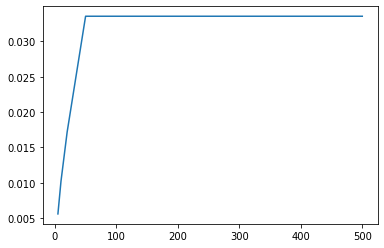

In [24]:
plt.plot(k_list, score)

C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

50

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [25]:
# your_code
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))

In [26]:
users_lvl_2.head(2)

,user_id,candidates
0,2070,"[1105426, 1097350, 879194, 948640, 928263, 944..."
1,2021,"[950935, 1119454, 835578, 863762, 1019142, 102..."


In [27]:
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
users_lvl_2['flag'] = 1

users_lvl_2.head(4)

,user_id,item_id,flag
0,2070,1105426,1
0,2070,1097350,1
0,2070,879194,1
0,2070,948640,1


In [28]:
users_lvl_2.shape[0]

107550

In [29]:
users_lvl_2['user_id'].nunique()

2151

In [30]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2.drop('flag', axis=1, inplace=True)

In [52]:
targets_lvl_2_val = data_val_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2_val['target'] = 1  # тут только покупки 

targets_lvl_2_val = users_lvl_2.merge(targets_lvl_2_val, on=['user_id', 'item_id'], how='left')

targets_lvl_2_val['target'].fillna(0, inplace= True)
targets_lvl_2_val.drop('flag', axis=1, inplace=True)

In [53]:
targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,average_basket_price,purchases_per_month,item_per_week
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.18786,1.416667,1.666667
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.18786,1.416667,1.000000


In [54]:
targets_lvl_2_val.head(2)

,user_id,item_id,target
0,2070,1105426,0.0
1,2070,1097350,0.0


(!) На каждого юзера 50 item_id-кандидатов

In [32]:
targets_lvl_2['target'].mean()

0.10460593102333061

In [33]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [34]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [35]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

In [55]:
targets_lvl_2_val = targets_lvl_2_val.merge(item_features, on='item_id', how='left')
targets_lvl_2_val = targets_lvl_2_val.merge(user_features, on='user_id', how='left')

In [36]:
#Средний чек
average_basket = data_train_lvl_2.groupby(['user_id','basket_id'])['sales_value'].mean().reset_index()
average_basket.columns = ['user_id', 'basket_id', 'average_basket_price']
average_basket = average_basket.groupby('user_id')['average_basket_price'].mean().reset_index()

In [37]:
targets_lvl_2 = targets_lvl_2.merge(average_basket, on='user_id', how='left')

In [64]:
#Средний чек
average_basket_val = data_val_lvl_2.groupby(['user_id','basket_id'])['sales_value'].mean().reset_index()
average_basket_val.columns = ['user_id', 'basket_id', 'average_basket_price']
average_basket_val = average_basket_val.groupby('user_id')['average_basket_price'].mean().reset_index()

In [65]:
targets_lvl_2_val = targets_lvl_2_val.merge(average_basket_val, on='user_id', how='left')

In [38]:
#Частотность покупок раз/месяц
frequency = data_train_lvl_2.copy()
frequency['activity_per_month']=frequency['day']%30
frequency.drop_duplicates(subset ="basket_id", keep = False, inplace = True) 
frequency = frequency.groupby(['user_id', 'activity_per_month'])['basket_id'].count().reset_index()
frequency = frequency.groupby('user_id')['basket_id'].mean().reset_index()
frequency.columns = ['user_id', 'purchases_per_month']
frequency.head(2)

,user_id,purchases_per_month
0,1,1.0
1,2,1.0


In [39]:
targets_lvl_2 = targets_lvl_2.merge(frequency, on='user_id', how='left')

In [57]:
#Частотность покупок раз/месяц
frequency_val = data_val_lvl_2.copy()
frequency_val ['activity_per_month']=frequency_val['day']%30
frequency_val .drop_duplicates(subset ="basket_id", keep = False, inplace = True) 
frequency_val  = frequency_val .groupby(['user_id', 'activity_per_month'])['basket_id'].count().reset_index()
frequency_val  = frequency_val .groupby('user_id')['basket_id'].mean().reset_index()
frequency_val .columns = ['user_id', 'purchases_per_month']
frequency_val .head(2)

,user_id,purchases_per_month
0,1,1.0
1,6,1.0


In [58]:
targets_lvl_2_val = targets_lvl_2_val.merge(frequency, on='user_id', how='left')

In [40]:
#Кол-во покупок товара в неделю
item_per_week = data_train_lvl_2.groupby(['item_id','week_no'])['quantity'].sum().reset_index()
item_per_week = item_per_week.groupby('item_id')['quantity'].mean().reset_index()
item_per_week.columns = ['item_id', 'item_per_week']

In [41]:
targets_lvl_2 = targets_lvl_2.merge(item_per_week, on='item_id', how='left')

In [42]:
targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,average_basket_price,purchases_per_month,item_per_week
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.18786,1.416667,1.666667
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.18786,1.416667,1.000000


In [59]:
#Кол-во покупок товара в неделю
item_per_week_val = data_val_lvl_2.groupby(['item_id','week_no'])['quantity'].sum().reset_index()
item_per_week_val = item_per_week_val.groupby('item_id')['quantity'].mean().reset_index()
item_per_week_val.columns = ['item_id', 'item_per_week']

In [60]:
targets_lvl_2_val = targets_lvl_2_val.merge(item_per_week, on='item_id', how='left')

In [44]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [66]:
X_val = targets_lvl_2_val.drop('target', axis=1)
y_val = targets_lvl_2_val[['target']]

In [67]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'average_basket_price',
 'purchases_per_month',
 'item_per_week']

In [68]:
cat_feats = X_val.columns[2:].tolist()
X_val[cat_feats] = X_val[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'purchases_per_month',
 'item_per_week',
 'average_basket_price']

In [46]:
lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats)
lgb.fit(X_train, y_train)

train_preds = lgb.predict(X_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:814: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


In [69]:
val_preds = lgb.predict(X_val)

In [48]:
recall_at_k(train_preds, y_train)

0.8953940689766694

In [70]:
recall_at_k(val_preds, y_val)

0.9327005802778744

In [75]:
precision_at_k(train_preds, y_train)

19933.8

In [76]:
precision_at_k(val_preds, y_val)

20381.0

In [79]:

train_preds[:5]

array([0., 0., 0., 0., 0.])

### Финальный проект

Мы уже прошли всю необходимуб теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 25%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 

**Внимание**
Позже будет добавлено требование по метрике MAP@5